In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from econml.ortho_forest import ContinuousTreatmentOrthoForest as CausalForest

from copy import deepcopy

In [3]:
welfare = pd.read_csv("welfarelabel.csv", low_memory=False)
welfare

,year,id,wrkstat,hrs1,hrs2,evwork,occ,prestige,wrkslf,wrkgovt,...,preteen_miss,teens_miss,adults_miss,unrelat_miss,earnrs_miss,income_miss,rincome_miss,income86_miss,partyid_miss,polviews_miss
0,1986,1,working fulltime,40.000000,38.613701,1.1395408,270.00000,44.000000,someone else,private,...,0,0,0,0,0,0,0,0,0,0
1,1986,2,keeping house,41.733318,38.613701,1,195.00000,51.000000,someone else,private,...,0,0,0,1,0,0,1,0,0,0
2,1986,3,working fulltime,40.000000,38.613701,1.1395408,184.00000,51.000000,someone else,private,...,0,0,0,1,0,0,0,0,0,0
3,1986,4,retired,41.733318,38.613701,1,311.00000,36.000000,someone else,1,...,0,0,0,0,0,0,1,0,0,0
4,1986,5,working parttime,41.733318,38.613701,1.1395408,449.41599,40.335918,someone else,1.8203658,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36496,2010,2040,retired,41.733318,38.613701,1,449.41599,40.335918,someone else,private,...,0,0,0,0,0,0,1,1,0,0
36497,2010,2041,retired,41.733318,38.613701,1,449.41599,40.335918,someone else,private,...,0,0,0,0,0,0,1,1,0,0
36498,2010,2042,working fulltime,40.000000,38.613701,1.1395408,449.41599,40.335918,someone else,private,...,0,0,0,1,0,0,0,1,0,0
36499,2010,2043,working fulltime,49.000000,38.613701,1.1395408,449.41599,40.335918,someone else,private,...,0,0,0,1,0,0,1,1,0,0


Just a reference point to see how many actual covariates are in the Welfare dataset

In [4]:
def dropDummy(cols):
    filtered = []
    for col in cols:
        if "_" not in col:
            filtered.append(col)
    return filtered

realCols = dropDummy(list(welfare.columns))
print("Number of covariates for the welfare data set is", len(realCols) - 1) # Approximate number of covariates, we drop one column because of the label column

Number of covariates for the welfare data set is 61


Generating data (per page 17 of BART and BCF paper)

In [5]:
"""
Execute heterogeneous treatment on data

Returns: X, X@betas
"""
def heterogeneousTreatment(X, treatments, betas, effect):
    xb = X@betas
    for i in range(X.shape[0]):
        if int(treatments[i]) > 0:
            xb[i] += 1 + effect * X[i][1] * X[i][4] # heterogeneous treatment is 1 + effect*x_2*x_5
    X = np.append(X, treatments, axis=1)
    return X, xb


In [53]:
"""
Data Generating Process
    Configure treatment effect heterogeneity, independent of regression form and sample size

Params:
    effect_type - heterogeneous vs homogeneous
    effect_homogeneous - if effect_type is homogeneous, controls what the treatment coefficient is
    effect_heterogeneous - if effect_type is heterogeneous, controls n where the treatment coefficient is 1 + n * x_2 * x_5
    treatment_probability - probability that an observation is assigned the treatment, default is 0.5
    order - order of interactions between covariates desired, as order is increased, number of covariates and nonlinearity (if specified) is also increased
    linear - flag to control whether the dgp has exponents larger than 1 
    cc - number of continuous covariates to be included (pre-introduction of n order interactions)
    N - sample size
    rho - variance between continuous covariates
Returns: y, X, betas, features
"""
def dgp(effect_type="heterogeneous", effect_homogeneous=3, effect_heterogeneous=2,
        treatment_probability=0.5, order=3, linear=False, cc=4, N=1000, rho=0.2):
    
    error = np.random.normal(size=(N,1))
    
    added_covariates = 2
    if linear: 
        # linear => include 2 more continuous covariates
        # to have approximately same number of covariates between the linear and nonlinear cases
        cov = (np.eye(cc+added_covariates) * (1-rho)) + (np.ones((cc+added_covariates, cc+added_covariates)) * rho)

        # generate N continuous covariates of X
        X = np.random.multivariate_normal(np.zeros(cc+added_covariates), 
            cov, size=N, check_valid='warn', tol=1e-8) 
    else:
        cov = (np.eye(cc) * (1-rho)) + (np.ones((cc, cc)) * rho)

        # generate N continuous covariates of X
        X = np.random.multivariate_normal(np.zeros(cc), 
            cov, size=N, check_valid='warn', tol=1e-8)

    # add binary [0, 1] covariate
    X = np.append(X, np.random.randint(2, size=N).reshape((-1, 1)), axis=1) # add binary [0, 1] covariate

    cat_elements = [1, 2, 3]
    cat_probabilities = [0.2, 0.5, 0.3] # arbitrary

    # add unordered categorical [1, 2, 3] covariate
    X = np.append(X, np.random.choice(cat_elements, size=N, p=cat_probabilities).reshape((-1, 1)), axis=1)

    # add N order interactions if linear is false for X covariates
    # increases number of covariates (to have a high dimensional dataset)
    poly = PolynomialFeatures(order, interaction_only=linear) 
    X = poly.fit_transform(X)
    X = X[:,1:] # drop the constant term
    features = (poly.get_feature_names()[1:])
    features.append("w")

    treat_elements = [0, 1]
    treat_probabilities = [1 - treatment_probability, treatment_probability]

    # randomly assigned treatments with propensity treatment_probability
    treatments = np.random.choice(treat_elements, size=N, p=treat_probabilities).reshape((-1, 1))
    
    # heterogeneous vs. homogeneous treatments
    if effect_type == "homogeneous":
        betas = np.append(np.random.normal(size=X.shape[1]), [effect_homogeneous]).reshape(-1,1)
        X = np.append(X, treatments, axis=1)
        xb = X@betas
    else:
        betas = np.random.normal(size=X.shape[1]).reshape(-1,1)
        X, xb = heterogeneousTreatment(X, treatments, betas, effect_heterogeneous)

    y = xb + error 
    return y, X, betas, features, treatments


> "We find that including an estimate of the
propensity score as a covariate reduces the bias of regularized treatment effect estimates
in finite samples. We recommend including an estimated propensity score as a covariate
as routine practice regardless of the particular models or algorithms used to estimate
treatment effects since regularization is necessary to estimate heterogeneous treatment
effects non- or semiparamaterically or in high dimensions. To illustrate the potential for
biased estimation and motivate our fix, we introduce two key concepts: Regularization
induced confounding and targeted selection."

page 7, (Hahn, Murray, and Carlvaho)

=> i dont' think we are doing propensity score or regularization induced confounding or targeted selection.

$Y = \alpha Z + X \beta + \epsilon $ where $Z$ is the indicator of treatment, $\alpha$ ATE

We assume:
- observational/experimental (which one?) data
- conditional unfoundedness/ignorability
- covariate-dependent treatment effects => individuals can have different responses to treatment according to their covariates
- binary treatments (not continuous)

we write $ E(Y_i | x_i, z_i) = f(x_i, z_i) $

we want $\tau(x_i) := f(x_i, 1) - f(x_i, 0) = ATT - ATC$

In all cases the estimands of interest are either conditional average treatment effects for individual i accounting for all the variables, estimated by the posterior mean
treatment effect $\tau(x_i)$, or sample subgroup average treatment effects estimated by
$\Sigma_{i\in S} \tau(x_i)$, where S is the subgroup of interest. Credible intervals are computed from
MCMC output.

In [117]:
# generate data from DGP
effect_type = "homogeneous"
y, X, trueBetas, featureNames, treatments = dgp(effect_type=effect_type, 
                                                order=3, treatment_probability=0.5, linear=True)

# split data into train and test sets 
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(X, y, treatments, test_size=0.33)

# homo => no covariates affecting treatment
if effect_type == "homogeneous":
    W_train = None
    W_test = None
else:
    W_train = X_train[:, [1, 4]] # effect_modifiers
    W_test = X_test[:, [1, 4]]

In [118]:
from econml.dml import CausalForestDML
from sklearn.linear_model import LassoCV
from econml.inference import BootstrapInference

# specify hyperparams of model
est = CausalForestDML(criterion='mse', n_estimators=500,       
                      min_samples_leaf=10, 
                      max_depth=10, max_samples=0.5,
                      discrete_treatment=False,
                      model_t=LassoCV(), model_y=LassoCV())

# fit model
est.fit(Y_train.ravel(), T_train, X=X_train, W=W_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [119]:
# Estimate the treatment effects on test set
treatment_effects = est.effect(X_test)

# Confidence intervals via Bootstrap-of-Little-Bags for forests
lb, ub = est.effect_interval(X_test, alpha=0.05)

# Estimate the CATE with the test set
est.const_marginal_ate(X_test)

array([19.46082832])

 93%|=================== | 625/670 [00:13<00:00]       

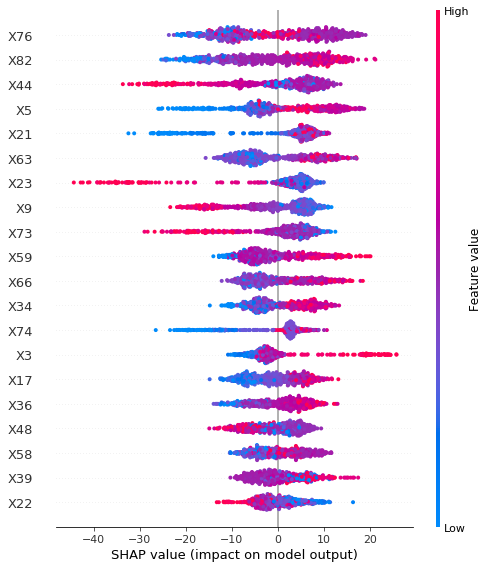

In [107]:
# Shapley values show covariate/feature w greatest importance on outcome,
# helps identify subgroups
shap_values = est.shap_values(X_train)

shap.summary_plot(shap_values['Y0']['T0'])

Above I am just trying to fit the CausalForest Model to our DGP. I don't understand the estimates just yet (why it's not exactly 3 or close to 3)

# Example of using CausalForestDML

In [40]:
import pandas as pd
from IPython.display import Image, display

# read Stata .dta file 
df = pd.read_stata("practice_data.dta")

# set variables 
treatment = 'treatment'
outcome = 'loansamt_total'
covariates = ["members_resid_bl", "nadults_resid_bl", "head_age_bl", "act_livestock_bl", "act_business_bl",
              "borrowed_total_bl", "members_resid_d_bl", "nadults_resid_d_bl", "head_age_d_bl",
              "act_livestock_d_bl", "act_business_d_bl", "borrowed_total_d_bl", "ccm_resp_activ",
              "other_resp_activ", "ccm_resp_activ_d", "other_resp_activ_d", "head_educ_1", "nmember_age6_16"]

In [34]:
# drop missing data
all_variables = deepcopy(covariates)
all_variables.append(treatment)
all_variables.append(outcome)
df = df.dropna(axis=0, subset=all_variables)

# split data into train and test sets 
train, test = train_test_split(df, test_size=0.2)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
Y = train[outcome]
T = train[treatment]
X = train[covariates]
W = None
X_test = test[covariates]

In [39]:

from econml.dml import CausalForestDML
from sklearn.linear_model import MultiTaskLassoCV


# set parameters for causal forest 
causal_forest = CausalForestDML(criterion='het', 
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), 
                                model_y=LassoCV(),
                                )
                      
# fit train data to causal forest model 
causal_forest.fit(Y, T, X=X, W=W)
# estimate the CATE with the test set 
causal_forest.const_marginal_ate(X_test)

In [44]:
"""
The code snippet below shows how to reset the parameters
of the causal forest and subsequently fit the causal forest
model again, in order to calculate SHAP values. It is necessary
to reset the parameters to the default values before refitting
the model, because with the parameters described above for
estimating the CATE, the runtime will be almost two hours.
"""
import shap

# fit causal forest with default parameters 
causal_forest = CausalForestDML()
causal_forest.fit(Y, T, X=X, W=W)

# calculate shap values of causal forest model 
shap_values = causal_forest.shap_values(X)

# plot shap values 
# shap.summary_plot(shap_values['Y0']['T0'])

 99%|===================| 4383/4406 [00:48<00:00]        

AttributeError: 'dict' object has no attribute 'shape'